In [1]:
%cd /home/research_dh/project/packages/emulator
%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/research_dh/project/packages/emulator


In [2]:
from model import Emulator, Unet
from pairDataset import make_file_list, PairDataset, Mel_fn_bigvgan
from utils import get_config, load_wav
import torch
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import librosa as lr
import auraloss # MSTFT, ESR, spectral log-magnitude(LSD)
from torchinfo import summary

In [ ]:
model_name = "real_play_l_v2"
config_path = "/home/research_dh/project/packages/emulator/config_l_v2.json"
ckpt_path = "/home/research_dh/project/ckpt/unet"
valid_dir = "/home/research_dh/project/data/data/validation/unseen"
device = "cuda:0"
h = get_config(config_path)

model = Emulator(model_name, h, ckpt_path, device).to(device)
model.eval()

x = []
for i in (2, 3, 4, 5, 7, 10, 15, 20, 30, 45, 60, 90, 120):
    x.append(torch.rand((int(i * 44100))))

emb = torch.zeros((4)).to(device)
with torch.no_grad():
    for i, k in enumerate(range(len(x))):
        print(f"\n{i} : ")
        model(x[k], emb)

/home/research_dh/project/packages/emulator/model.py:314: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_ckpt = torch.load(unet_ckpt_path, map_location=self.device)
/hom

unet ckpt loaded
Removing weight norm...

0 : 
torch.Size([172, 128])
torch.Size([128, 0])


RuntimeError: Calculated padded input size per channel: (6). Kernel size: (7). Kernel size can't be greater than actual input size

In [13]:
config_path = "/home/research_dh/project/packages/emulator/config_l_v2.json"
h = get_config(config_path)
model_l = Unet(h)

summary(model_l)

Layer (type:depth-idx)                        Param #
Unet                                          --
├─Encoder: 1-1                                --
│    └─ModuleList: 2-1                        --
│    │    └─Conv2d: 3-1                       832
│    │    └─ReLU: 3-2                         --
│    │    └─Conv2d: 3-3                       25,632
│    │    └─ReLU: 3-4                         --
│    │    └─MaxPool2d: 3-5                    --
│    │    └─Conv2d: 3-6                       51,264
│    │    └─ReLU: 3-7                         --
│    │    └─Conv2d: 3-8                       102,464
│    │    └─ReLU: 3-9                         --
│    │    └─MaxPool2d: 3-10                   --
│    │    └─Conv2d: 3-11                      204,928
│    │    └─ReLU: 3-12                        --
│    │    └─Conv2d: 3-13                      409,728
│    │    └─ReLU: 3-14                        --
│    │    └─MaxPool2d: 3-15                   --
├─Decoder: 1-2                          

In [14]:
config_path = "/home/research_dh/project/packages/emulator/config_s_v2.json"
h = get_config(config_path)
model_s = Unet(h)

summary(model_s)

Layer (type:depth-idx)                        Param #
Unet                                          --
├─Encoder: 1-1                                --
│    └─ModuleList: 2-1                        --
│    │    └─Conv2d: 3-1                       640
│    │    └─ReLU: 3-2                         --
│    │    └─Conv2d: 3-3                       36,928
│    │    └─ReLU: 3-4                         --
│    │    └─MaxPool2d: 3-5                    --
│    │    └─Conv2d: 3-6                       73,856
│    │    └─ReLU: 3-7                         --
│    │    └─Conv2d: 3-8                       147,584
│    │    └─ReLU: 3-9                         --
│    │    └─MaxPool2d: 3-10                   --
├─Decoder: 1-2                                --
│    └─ModuleList: 2-2                        --
│    │    └─ConvTranspose2d: 3-11             131,200
│    │    └─Conv2d: 3-12                      295,040
│    │    └─ReLU: 3-13                        --
│    │    └─Conv2d: 3-14                

In [15]:
# Real play large
model_name = "real_play_l_v2"
config_path = "/home/research_dh/project/packages/emulator/config_l_v2.json"
ckpt_path = "/home/research_dh/project/ckpt/unet"
valid_dir = "/home/research_dh/project/data/data/validation/unseen"
device = "cuda:0"
h = get_config(config_path)

model = Emulator(model_name, h, ckpt_path, device).to(device)

x_list, y_list, emb = make_file_list(valid_dir, False)
emb = torch.stack(emb)
x = []
for f in x_list:
    x.append(load_wav(os.path.join(valid_dir, f)))
x = torch.stack(x)
y = []
for f in y_list:
    y.append(load_wav(os.path.join(valid_dir, f)))
y = torch.stack(y)

print(f"valid x shape {x.shape}")
print(f"valid y shape {y.shape}")
print(f"valid emb shape {emb.shape}")

# Cut the y in the length same as y_hat
# Take loss(y, y_pred)
# Get average for whole valid set
loss_fn_LSD = auraloss.freq.STFTLoss(w_sc=0, w_lin_mag=0, w_log_mag=1, sample_rate=44100)
loss_fn_MSTFT = auraloss.freq.MultiResolutionSTFTLoss(sample_rate=44100)
loss_fn_ESR = auraloss.time.ESRLoss()

length = x.shape[0]
y_hat = []
for i in range(length):
    with torch.no_grad():
        y_hat.append(model(x[i].to(device), emb[i].to(device)))
y_hat = torch.stack(y_hat)
print(y_hat.shape)

y = y[..., 0:y_hat.shape[-1]].to(device)
print(y.shape)

LSD = loss_fn_LSD(y.unsqueeze(1), y_hat.unsqueeze(1)).item()
MSTFT = loss_fn_MSTFT(y.unsqueeze(1), y_hat.unsqueeze(1)).item()
ESR = loss_fn_ESR(y, y_hat).item()

print(f"LSD : {LSD}")
print(f"MSTFT : {MSTFT}")
print(f"ESR : {ESR}")

mel_fn = Mel_fn_bigvgan(h.sampling_rate, h.n_fft, h.hop_size, h.n_mels, h.fmin, h.fmax)
valid_set = PairDataset(valid_dir, h.frame_size, mel_fn, True)
print(len(valid_set))
#batch_size = 32
#valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=False)
#print(len(valid_loader))
loss_fn_L1 = torch.nn.L1Loss(reduction='mean')

unet = Unet(h).to(device)
unet.eval()
ckpt_path = os.path.join("/home/research_dh/project/ckpt/unet", model_name + ".ckpt")
ckpt = torch.load(ckpt_path, map_location=device)
unet.load_state_dict(ckpt["model_state_dict"])

L1_loss = 0
min_loss = 99999999
with torch.no_grad():
    for i, (x, y, emb) in enumerate(valid_set):
        y_hat = unet(x.to(device), emb.to(device))
        loss = loss_fn_L1(y.to('cpu'), y_hat.to('cpu')).item()
        if min_loss > loss:
            min_loss = loss
            min_idx = i
        L1_loss = L1_loss + loss
'''
L1_loss_loader = 0
print("------------------------")
with torch.no_grad():
    for x,  y, emb in valid_loader:
        y_hat = unet(x.to(device), emb.to(device))
        L1_loss_loader = L1_loss_loader + loss_fn_L1(y.to('cpu'), y_hat.to('cpu')).item() * x.shape[0]
        print(L1_loss_loader)
L1_loss_loader = L1_loss_loader / len(valid_set)
print(L1_loss_loader)
'''

L1_loss = L1_loss / len(valid_set)
print(f"Mel L1 loss : {L1_loss}")
print(f"minimum loss : @ {min_idx} {min_loss}")

unet ckpt loaded
Removing weight norm...
valid x shape torch.Size([6, 1323000])
valid y shape torch.Size([6, 1323000])
valid emb shape torch.Size([6, 4])
torch.Size([6, 1310720])
torch.Size([6, 1310720])
LSD : 0.8938937187194824
MSTFT : 1.3097728490829468
ESR : 1.916242003440857
120


/tmp/ipykernel_979808/1894361988.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


Mel L1 loss : 0.6118609411021073
minimum loss : @ 37 0.30733975768089294


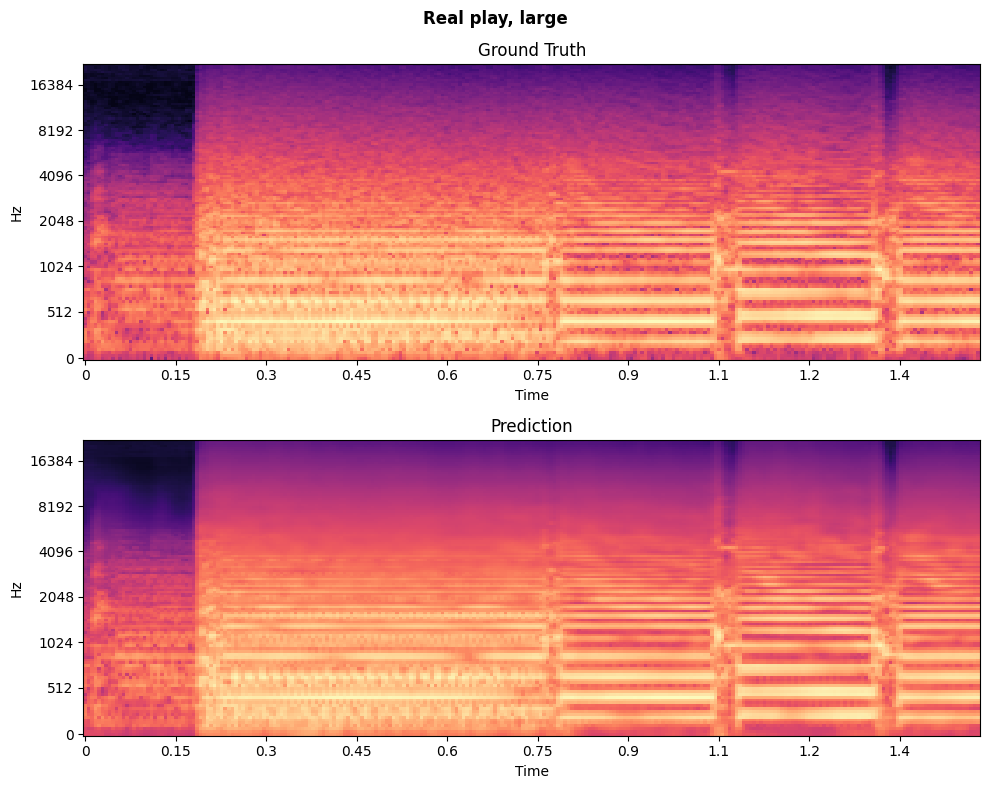

In [16]:
mel_x, mel_y, mel_emb = valid_set[min_idx]
mel_y = mel_y.to('cpu')
with torch.no_grad():
    mel_y_hat = unet(mel_x.to(device), mel_emb.to(device)).to('cpu')
vmin = min(torch.min(mel_y).item(), torch.min(mel_y_hat).item())
vmax = max(torch.max(mel_y).item(), torch.max(mel_y_hat).item())

fig = plt.figure(figsize=(10, 8))
plt.suptitle("Real play, large", fontweight="bold")
ax1 = fig.add_subplot(211)
ax1.set_title("Ground Truth")
f1 = lr.display.specshow(mel_y.T.numpy(), y_axis='mel', sr=h.sampling_rate, hop_length=h.hop_size, x_axis='time', fmin=h.fmin, fmax=h.fmax, ax=ax1, vmin=-12, vmax=0)

ax2 = fig.add_subplot(212)
ax2.set_title("Prediction")
f2 = lr.display.specshow(mel_y_hat.T.numpy(), y_axis='mel', sr=h.sampling_rate, hop_length=h.hop_size, x_axis='time', fmin=h.fmin, fmax=h.fmax, vmin=-12, vmax=0)
plt.tight_layout()
plt.show()

In [17]:
# Real play small

model_name = "real_play_s_v2"
config_path = "/home/research_dh/project/packages/emulator/config_s_v2.json"
ckpt_path = "/home/research_dh/project/ckpt/unet"
valid_dir = "/home/research_dh/project/data/data/validation/unseen"
device = "cuda:0"
h = get_config(config_path)

model = Emulator(model_name, h, ckpt_path, device).to(device)

x_list, y_list, emb = make_file_list(valid_dir, False)
emb = torch.stack(emb)
x = []
for f in x_list:
    x.append(load_wav(os.path.join(valid_dir, f)))
x = torch.stack(x)
y = []
for f in y_list:
    y.append(load_wav(os.path.join(valid_dir, f)))
y = torch.stack(y)

print(f"valid x shape {x.shape}")
print(f"valid y shape {y.shape}")
print(f"valid emb shape {emb.shape}")

# Cut the y in the length same as y_hat
# Take loss(y, y_pred)
# Get average for whole valid set
loss_fn_LSD = auraloss.freq.STFTLoss(w_sc=0, w_lin_mag=0, w_log_mag=1, sample_rate=44100)
loss_fn_MSTFT = auraloss.freq.MultiResolutionSTFTLoss(sample_rate=44100)
loss_fn_ESR = auraloss.time.ESRLoss()

length = x.shape[0]
y_hat = []
for i in range(length):
    with torch.no_grad():
        y_hat.append(model(x[i].to(device), emb[i].to(device)))
y_hat = torch.stack(y_hat)
print(y_hat.shape)

y = y[..., 0:y_hat.shape[-1]].to(device)
print(y.shape)

LSD = loss_fn_LSD(y.unsqueeze(1), y_hat.unsqueeze(1)).item()
MSTFT = loss_fn_MSTFT(y.unsqueeze(1), y_hat.unsqueeze(1)).item()
ESR = loss_fn_ESR(y, y_hat).item()

print(f"LSD : {LSD}")
print(f"MSTFT : {MSTFT}")
print(f"ESR : {ESR}")

mel_fn = Mel_fn_bigvgan(h.sampling_rate, h.n_fft, h.hop_size, h.n_mels, h.fmin, h.fmax)
valid_set = PairDataset(valid_dir, h.frame_size, mel_fn, True)
print(len(valid_set))
#batch_size = 32
#valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=False)
#print(len(valid_loader))
loss_fn_L1 = torch.nn.L1Loss(reduction='mean')

unet = Unet(h).to(device)
unet.eval()
ckpt_path = os.path.join("/home/research_dh/project/ckpt/unet", model_name + ".ckpt")
ckpt = torch.load(ckpt_path, map_location=device)
unet.load_state_dict(ckpt["model_state_dict"])

L1_loss = 0
min_loss = 99999999
with torch.no_grad():
    for i, (x, y, emb) in enumerate(valid_set):
        y_hat = unet(x.to(device), emb.to(device))
        loss = loss_fn_L1(y.to('cpu'), y_hat.to('cpu')).item()
        if min_loss > loss:
            min_loss = loss
            min_idx = i
        L1_loss = L1_loss + loss
'''
L1_loss_loader = 0
print("------------------------")
with torch.no_grad():
    for x,  y, emb in valid_loader:
        y_hat = unet(x.to(device), emb.to(device))
        L1_loss_loader = L1_loss_loader + loss_fn_L1(y.to('cpu'), y_hat.to('cpu')).item() * x.shape[0]
        print(L1_loss_loader)
L1_loss_loader = L1_loss_loader / len(valid_set)
print(L1_loss_loader)
'''

L1_loss = L1_loss / len(valid_set)
print(f"Mel L1 loss : {L1_loss}")
print(f"minimum loss : @ {min_idx} {min_loss}")

unet ckpt loaded
Removing weight norm...
valid x shape torch.Size([6, 1323000])
valid y shape torch.Size([6, 1323000])
valid emb shape torch.Size([6, 4])
torch.Size([6, 1310720])
torch.Size([6, 1310720])
LSD : 0.9005641937255859
MSTFT : 1.2763622999191284
ESR : 1.9605745077133179
120


/tmp/ipykernel_979808/1311894211.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


Mel L1 loss : 0.5786083656052748
minimum loss : @ 97 0.3672119081020355


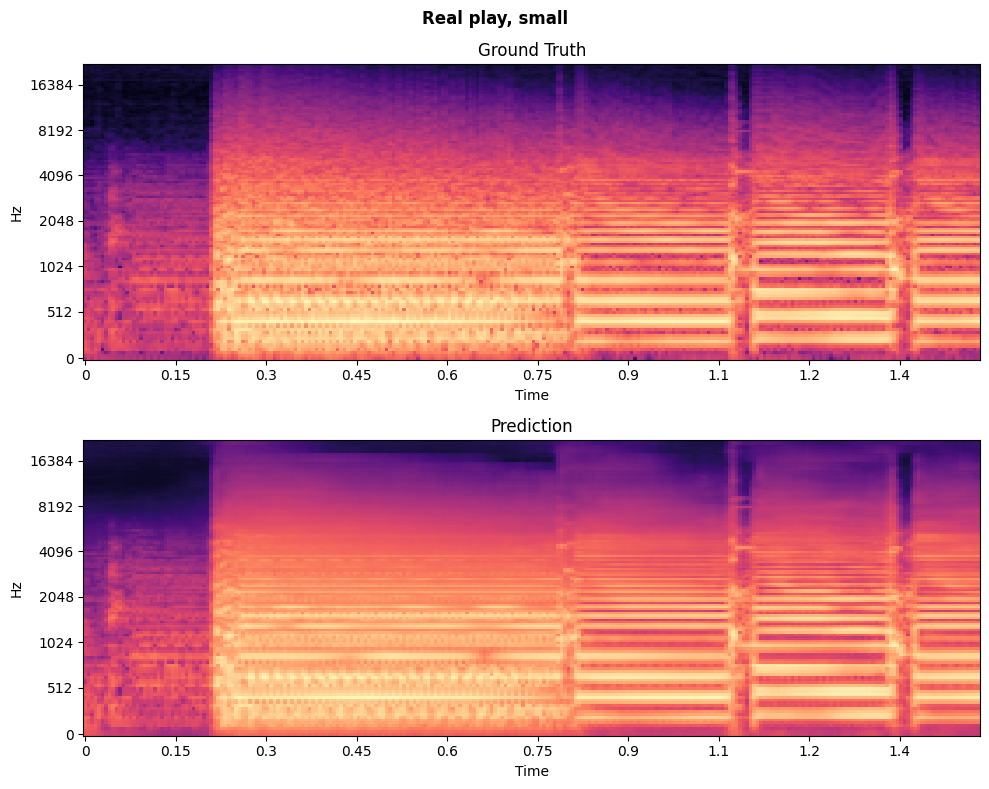

In [18]:
mel_x, mel_y, mel_emb = valid_set[min_idx]
mel_y = mel_y.to('cpu')
with torch.no_grad():
    mel_y_hat = unet(mel_x.to(device), mel_emb.to(device)).to('cpu')
vmin = min(torch.min(mel_y).item(), torch.min(mel_y_hat).item())
vmax = max(torch.max(mel_y).item(), torch.max(mel_y_hat).item())

fig = plt.figure(figsize=(10, 8))
plt.suptitle("Real play, small", fontweight="bold")
ax1 = fig.add_subplot(211)
ax1.set_title("Ground Truth")
f1 = lr.display.specshow(mel_y.T.numpy(), y_axis='mel', sr=h.sampling_rate, hop_length=h.hop_size, x_axis='time', fmin=h.fmin, fmax=h.fmax, ax=ax1, vmin=-12, vmax=0)

ax2 = fig.add_subplot(212)
ax2.set_title("Prediction")
f2 = lr.display.specshow(mel_y_hat.T.numpy(), y_axis='mel', sr=h.sampling_rate, hop_length=h.hop_size, x_axis='time', fmin=h.fmin, fmax=h.fmax, vmin=-12, vmax=0)
plt.tight_layout()
plt.show()

In [19]:
# White noise large

model_name = "white_noise_l_v2"
config_path = "/home/research_dh/project/packages/emulator/config_l_v2.json"
ckpt_path = "/home/research_dh/project/ckpt/unet"
valid_dir = "/home/research_dh/project/data/data/validation/unseen"
device = "cuda:0"
h = get_config(config_path)

model = Emulator(model_name, h, ckpt_path, device).to(device)

x_list, y_list, emb = make_file_list(valid_dir, False)
emb = torch.stack(emb)
x = []
for f in x_list:
    x.append(load_wav(os.path.join(valid_dir, f)))
x = torch.stack(x)
y = []
for f in y_list:
    y.append(load_wav(os.path.join(valid_dir, f)))
y = torch.stack(y)

print(f"valid x shape {x.shape}")
print(f"valid y shape {y.shape}")
print(f"valid emb shape {emb.shape}")

# Cut the y in the length same as y_hat
# Take loss(y, y_pred)
# Get average for whole valid set
loss_fn_LSD = auraloss.freq.STFTLoss(w_sc=0, w_lin_mag=0, w_log_mag=1, sample_rate=44100)
loss_fn_MSTFT = auraloss.freq.MultiResolutionSTFTLoss(sample_rate=44100)
loss_fn_ESR = auraloss.time.ESRLoss()

length = x.shape[0]
y_hat = []
for i in range(length):
    with torch.no_grad():
        y_hat.append(model(x[i].to(device), emb[i].to(device)))
y_hat = torch.stack(y_hat)
print(y_hat.shape)

y = y[..., 0:y_hat.shape[-1]].to(device)
print(y.shape)

LSD = loss_fn_LSD(y.unsqueeze(1), y_hat.unsqueeze(1)).item()
MSTFT = loss_fn_MSTFT(y.unsqueeze(1), y_hat.unsqueeze(1)).item()
ESR = loss_fn_ESR(y, y_hat).item()

print(f"LSD : {LSD}")
print(f"MSTFT : {MSTFT}")
print(f"ESR : {ESR}")

mel_fn = Mel_fn_bigvgan(h.sampling_rate, h.n_fft, h.hop_size, h.n_mels, h.fmin, h.fmax)
valid_set = PairDataset(valid_dir, h.frame_size, mel_fn, True)
print(len(valid_set))
#batch_size = 32
#valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=False)
#print(len(valid_loader))
loss_fn_L1 = torch.nn.L1Loss(reduction='mean')

unet = Unet(h).to(device)
unet.eval()
ckpt_path = os.path.join("/home/research_dh/project/ckpt/unet", model_name + ".ckpt")
ckpt = torch.load(ckpt_path, map_location=device)
unet.load_state_dict(ckpt["model_state_dict"])

L1_loss = 0
min_loss = 99999999
with torch.no_grad():
    for i, (x, y, emb) in enumerate(valid_set):
        y_hat = unet(x.to(device), emb.to(device))
        loss = loss_fn_L1(y.to('cpu'), y_hat.to('cpu')).item()
        if min_loss > loss:
            min_loss = loss
            min_idx = i
        L1_loss = L1_loss + loss
'''
L1_loss_loader = 0
print("------------------------")
with torch.no_grad():
    for x,  y, emb in valid_loader:
        y_hat = unet(x.to(device), emb.to(device))
        L1_loss_loader = L1_loss_loader + loss_fn_L1(y.to('cpu'), y_hat.to('cpu')).item() * x.shape[0]
        print(L1_loss_loader)
L1_loss_loader = L1_loss_loader / len(valid_set)
print(L1_loss_loader)
'''

L1_loss = L1_loss / len(valid_set)
print(f"Mel L1 loss : {L1_loss}")
print(f"minimum loss : @ {min_idx} {min_loss}")

unet ckpt loaded
Removing weight norm...
valid x shape torch.Size([6, 1323000])
valid y shape torch.Size([6, 1323000])
valid emb shape torch.Size([6, 4])
torch.Size([6, 1310720])
torch.Size([6, 1310720])
LSD : 1.5878322124481201
MSTFT : 2.8740439414978027
ESR : 4.734471321105957


FileNotFoundError: [Errno 2] No such file or directory: '/home/research_dh/project/data/data/validation/unseen'

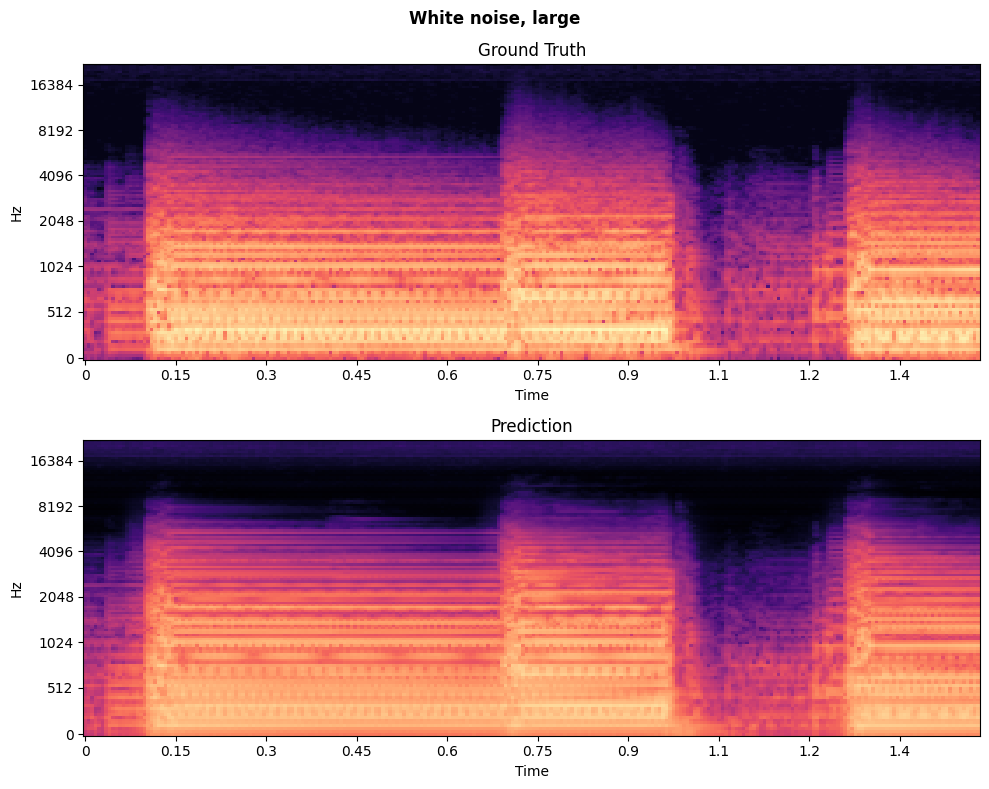

In [ ]:
mel_x, mel_y, mel_emb = valid_set[min_idx]
mel_y = mel_y.to('cpu')
with torch.no_grad():
    mel_y_hat = unet(mel_x.to(device), mel_emb.to(device)).to('cpu')
vmin = min(torch.min(mel_y).item(), torch.min(mel_y_hat).item())
vmax = max(torch.max(mel_y).item(), torch.max(mel_y_hat).item())

fig = plt.figure(figsize=(10, 8))
plt.suptitle("White noise, large", fontweight="bold")
ax1 = fig.add_subplot(211)
ax1.set_title("Ground Truth")
f1 = lr.display.specshow(mel_y.T.numpy(), y_axis='mel', sr=h.sampling_rate, hop_length=h.hop_size, x_axis='time', fmin=h.fmin, fmax=h.fmax, ax=ax1, vmin=-12, vmax=0)

ax2 = fig.add_subplot(212)
ax2.set_title("Prediction")
f2 = lr.display.specshow(mel_y_hat.T.numpy(), y_axis='mel', sr=h.sampling_rate, hop_length=h.hop_size, x_axis='time', fmin=h.fmin, fmax=h.fmax, vmin=-12, vmax=0)
plt.tight_layout()
plt.show()

In [ ]:
# White nosie small

model_name = "white_noise_s_v2"
config_path = "/home/research_dh/project/packages/emulator/config_s_v2.json"
ckpt_path = "/home/research_dh/project/ckpt/unet"
valid_dir = "/home/research_dh/project/data/data/validation/unseen"
device = "cuda:0"
h = get_config(config_path)

model = Emulator(model_name, h, ckpt_path, device).to(device)

x_list, y_list, emb = make_file_list(valid_dir, False)
emb = torch.stack(emb)
x = []
for f in x_list:
    x.append(load_wav(os.path.join(valid_dir, f)))
x = torch.stack(x)
y = []
for f in y_list:
    y.append(load_wav(os.path.join(valid_dir, f)))
y = torch.stack(y)

print(f"valid x shape {x.shape}")
print(f"valid y shape {y.shape}")
print(f"valid emb shape {emb.shape}")

# Cut the y in the length same as y_hat
# Take loss(y, y_pred)
# Get average for whole valid set
loss_fn_LSD = auraloss.freq.STFTLoss(w_sc=0, w_lin_mag=0, w_log_mag=1, sample_rate=44100)
loss_fn_MSTFT = auraloss.freq.MultiResolutionSTFTLoss(sample_rate=44100)
loss_fn_ESR = auraloss.time.ESRLoss()

length = x.shape[0]
y_hat = []
for i in range(length):
    with torch.no_grad():
        y_hat.append(model(x[i].to(device), emb[i].to(device)))
y_hat = torch.stack(y_hat)
print(y_hat.shape)

y = y[..., 0:y_hat.shape[-1]].to(device)
print(y.shape)

LSD = loss_fn_LSD(y.unsqueeze(1), y_hat.unsqueeze(1)).item()
MSTFT = loss_fn_MSTFT(y.unsqueeze(1), y_hat.unsqueeze(1)).item()
ESR = loss_fn_ESR(y, y_hat).item()

print(f"LSD : {LSD}")
print(f"MSTFT : {MSTFT}")
print(f"ESR : {ESR}")

mel_fn = Mel_fn_bigvgan(h.sampling_rate, h.n_fft, h.hop_size, h.n_mels, h.fmin, h.fmax)
valid_set = PairDataset(valid_dir, h.frame_size, mel_fn, True)
print(len(valid_set))
#batch_size = 32
#valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=False)
#print(len(valid_loader))
loss_fn_L1 = torch.nn.L1Loss(reduction='mean')

unet = Unet(h).to(device)
unet.eval()
ckpt_path = os.path.join("/home/research_dh/project/ckpt/unet", model_name + ".ckpt")
ckpt = torch.load(ckpt_path, map_location=device)
unet.load_state_dict(ckpt["model_state_dict"])

L1_loss = 0
min_loss = 99999999
with torch.no_grad():
    for i, (x, y, emb) in enumerate(valid_set):
        y_hat = unet(x.to(device), emb.to(device))
        loss = loss_fn_L1(y.to('cpu'), y_hat.to('cpu')).item()
        if min_loss > loss:
            min_loss = loss
            min_idx = i
        L1_loss = L1_loss + loss
'''
L1_loss_loader = 0
print("------------------------")
with torch.no_grad():
    for x,  y, emb in valid_loader:
        y_hat = unet(x.to(device), emb.to(device))
        L1_loss_loader = L1_loss_loader + loss_fn_L1(y.to('cpu'), y_hat.to('cpu')).item() * x.shape[0]
        print(L1_loss_loader)
L1_loss_loader = L1_loss_loader / len(valid_set)
print(L1_loss_loader)
'''

L1_loss = L1_loss / len(valid_set)
print(f"Mel L1 loss : {L1_loss}")
print(f"minimum loss : @ {min_idx} {min_loss}")

unet ckpt loaded
Removing weight norm...
valid x shape torch.Size([6, 1323000])
valid y shape torch.Size([6, 1323000])
valid emb shape torch.Size([6, 4])
torch.Size([6, 1310720])
torch.Size([6, 1310720])
LSD : 1.36453378200531
MSTFT : 2.4437315464019775
ESR : 4.137134075164795
120


/tmp/ipykernel_958704/2688188657.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


Mel L1 loss : 0.8312705352902412
minimum loss : @ 52 0.5733353495597839


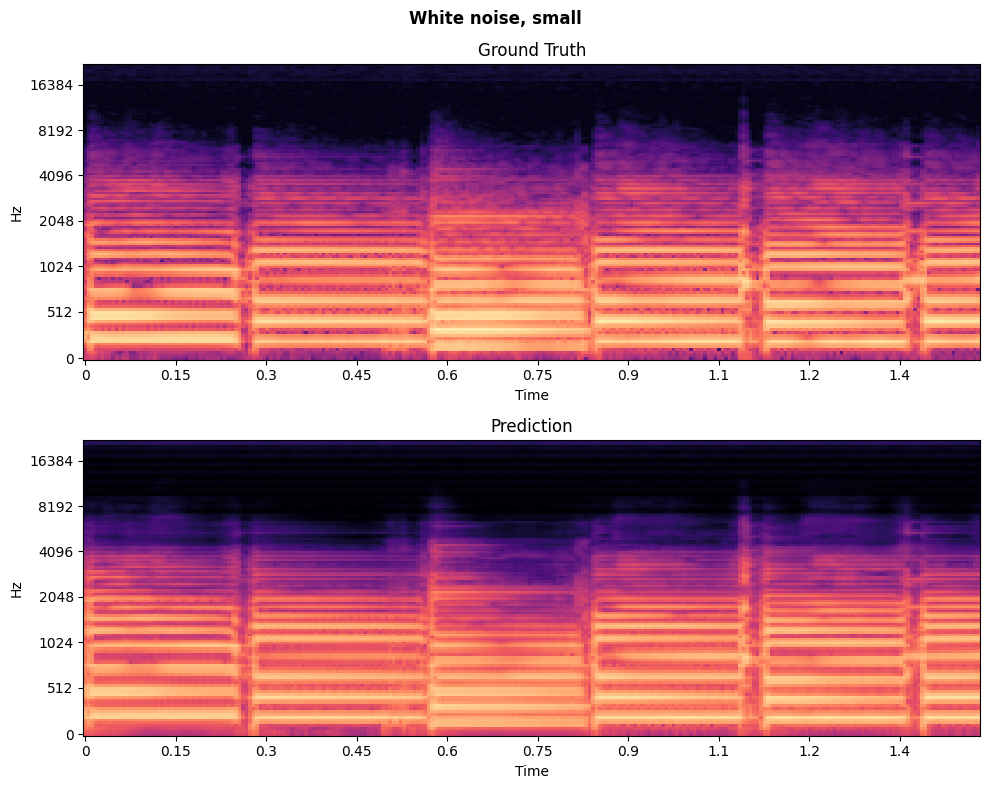

In [ ]:
mel_x, mel_y, mel_emb = valid_set[min_idx]
mel_y = mel_y.to('cpu')
with torch.no_grad():
    mel_y_hat = unet(mel_x.to(device), mel_emb.to(device)).to('cpu')
vmin = min(torch.min(mel_y).item(), torch.min(mel_y_hat).item())
vmax = max(torch.max(mel_y).item(), torch.max(mel_y_hat).item())

fig = plt.figure(figsize=(10, 8))
plt.suptitle("White noise, small", fontweight="bold")
ax1 = fig.add_subplot(211)
ax1.set_title("Ground Truth")
f1 = lr.display.specshow(mel_y.T.numpy(), y_axis='mel', sr=h.sampling_rate, hop_length=h.hop_size, x_axis='time', fmin=h.fmin, fmax=h.fmax, ax=ax1, vmin=-12, vmax=0)

ax2 = fig.add_subplot(212)
ax2.set_title("Prediction")
f2 = lr.display.specshow(mel_y_hat.T.numpy(), y_axis='mel', sr=h.sampling_rate, hop_length=h.hop_size, x_axis='time', fmin=h.fmin, fmax=h.fmax, vmin=-12, vmax=0)
plt.tight_layout()
plt.show()

In [ ]:
unet = Unet(h).to(device)
unet.eval()
ckpt_path = os.path.join("/home/research_dh/project/ckpt/unet", model_name + ".ckpt")
ckpt = torch.load(ckpt_path, map_location=device)
unet.load_state_dict(ckpt["model_state_dict"])

L1_loss = 0
min_loss = 99999999
with torch.no_grad():
    for i, (x, y, emb) in enumerate(valid_set):
        y_hat = unet(x.to(device), emb.to(device))
        loss = loss_fn_L1(y.to('cpu'), y_hat.to('cpu')).item()
        if min_loss > loss:
            min_loss = loss
            min_idx = i
        L1_loss = L1_loss + loss
'''
L1_loss_loader = 0
print("------------------------")
with torch.no_grad():
    for x,  y, emb in valid_loader:
        y_hat = unet(x.to(device), emb.to(device))
        L1_loss_loader = L1_loss_loader + loss_fn_L1(y.to('cpu'), y_hat.to('cpu')).item() * x.shape[0]
        print(L1_loss_loader)
L1_loss_loader = L1_loss_loader / len(valid_set)
print(L1_loss_loader)
'''

L1_loss = L1_loss / len(valid_set)
print(f"loss : {L1_loss}")
print(f"minimum loss : @{min_idx} {min_loss}")

/tmp/ipykernel_885254/2481563185.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


loss : 0.8312705352902412
minimum loss : @52 0.5733353495597839


In [ ]:
L1_loss = 0
L1_loss_loader = 0
for b, (x, y, emb) in enumerate(valid_loader):
    y_hat_loader = unet(x.to(device), emb.to(device))
    for i in range(x.shape[0]):
        if not torch.equal(valid_set[b * batch_size + i][0], x[i]):
            print(f"{b * 16 + i} x wrong")
        if not torch.equal(valid_set[b * batch_size + i][1], y[i]):
            print(f"{b * 16 + i} y wrong")
        if not torch.equal(valid_set[b * batch_size + i][2], emb[i]):
            print(f"{b * 16 + i} emb wrong")
        
        y_hat = unet(valid_set[b * batch_size + i][0].to(device), valid_set[b * batch_size + i][2].to(device))
        if loss_fn_L1(y_hat, y_hat_loader[i]) > 0.000001:
            print(f"{b * batch_size + i}, emb = {loss_fn_L1(y_hat, y_hat_loader[i])}")
    

In [ ]:
print(L1_loss)

0.6118609411021073
